# Install the required libraries.



In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem, DataStructs, RDConfig
from rdkit.Chem import (
    AllChem,
    PandasTools,
    Draw,
    Descriptors,
    MACCSkeys,
    rdFingerprintGenerator,
    GetAdjacencyMatrix
)

from rdkit.Chem.rdmolops import GetAdjacencyMatrix

from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True
%matplotlib inline

# Part 1: Exploring the dataset

---




## Import the data


In [2]:
url = 'https://raw.githubusercontent.com/ntua-unit-of-control-and-informatics/QSAR_PFAS/main/LogKow/LogKow_Training.csv'
comp_data = pd.read_csv(url)
print('Complete Dataset:\n',comp_data,'\n\n')

Complete Dataset:
                                                    Name  \
0                                Perfluorobutanoic acid   
1                       Perfluoropentanoic acid (PFPeA)   
2                        Perfluorohexanoic acid (PFHxA)   
3                       Perfluoroheptanoic acid (PFHpA)   
4                         Perfluorononanoic acid (PFNA)   
...                                                 ...   
1274  1,1-dichloro-3,3,3-trimethyl-1-(3,3,4,4,5,5,6,...   
1275  4-oxo-4-[(4,4,5,5,6,6,7,7,8,8,9,9,10,10,11,11,...   
1276  3-chloro-1,1,1,5,5,5-hexamethyl-3-(3,3,4,4,5,5...   
1277  Dimethoxymethyl(3,3,4,4,5,5,6,6,7,7,8,8,8-trid...   
1278  2-[[[dimethyl(3,3,4,4,5,5,6,6,7,7,8,8,8-tridec...   

                                                 SMILES  logKow_EPISuite  
0                          O=C(O)C(F)(F)C(F)(F)C(F)(F)F             2.14  
1                   O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F             2.81  
2            O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)

# View the molecules used for the model development



---
Create a data frame containing only the PFAS names


---




In [3]:
all_smiles = pd.DataFrame(comp_data['SMILES'], columns=['SMILES'])

---
Add the ROMol object in the data frame


---

In [4]:
PandasTools.AddMoleculeColumnToFrame(all_smiles, smilesCol="SMILES")
# Show first 4 molecules
all_smiles.head(4)
#pd.set_option('display.max_rows', 10)

[11:12:05] Explicit valence for atom # 0 N, 5, is greater than permitted
[11:12:05] Explicit valence for atom # 1 N, 4, is greater than permitted
[11:12:05] Explicit valence for atom # 0 N, 5, is greater than permitted
[11:12:05] Explicit valence for atom # 1 N, 4, is greater than permitted
[11:12:05] Explicit valence for atom # 1 N, 4, is greater than permitted


,SMILES,ROMol
0,O=C(O)C(F)(F)C(F)(F)C(F)(F)F,<rdkit.Chem.rdchem.Mol object at 0x0000029358F...
1,O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,<rdkit.Chem.rdchem.Mol object at 0x0000029358F...
2,O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,<rdkit.Chem.rdchem.Mol object at 0x0000029358F...
3,O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,<rdkit.Chem.rdchem.Mol object at 0x0000029358F...


Check if any ROMol values are None 

In [5]:
ToDrop = all_smiles[all_smiles['ROMol'].isna()].index.values.tolist()
# See which SMILES don't have a ROMol value
all_smiles[all_smiles['ROMol'].isna()] 

,SMILES,ROMol
30,[H][N]([H])([H])([H])OC(=O)C(F)(F)C(F)(F)C(F)(...,None
33,C[N](C)(O)CCCNS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(...,None
51,[H][N]([H])([H])([H])OC(=O)C(F)(F)C(F)(F)C(F)(...,None
66,C[N](C)(CCCNS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)...,None
107,C[N](C)(CCO)CCCN(CCCS(O)(=O)=O)S(=O)(=O)C(F)(F...,None


Drop PFAS that don't have a ROMol representation

In [6]:
all_smiles = all_smiles.drop(ToDrop)

---
Draw the first 9 molecules in the dataframe with SMILES strings


---

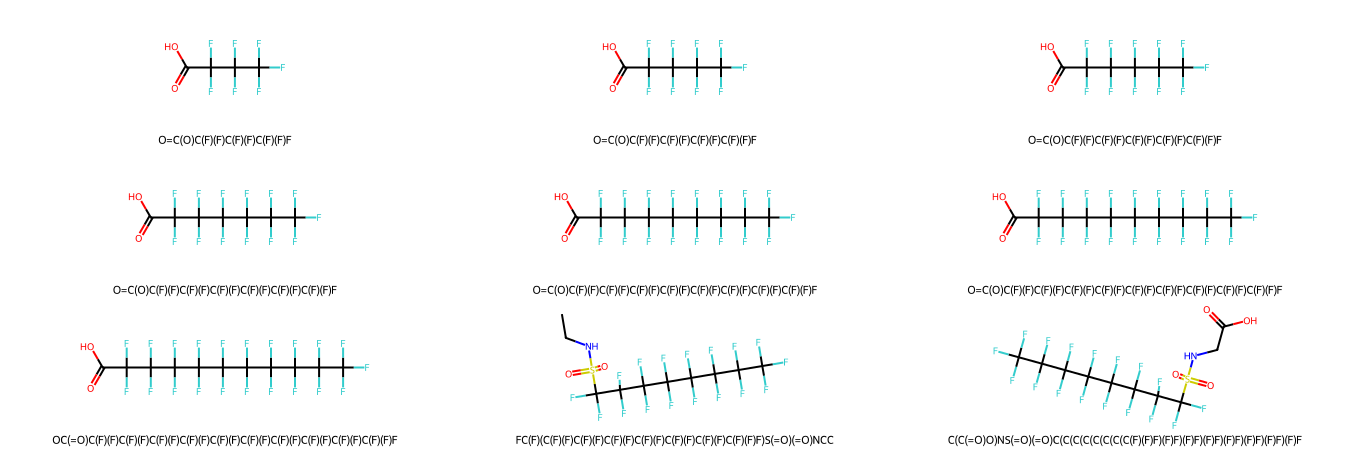

In [7]:
Draw.MolsToGridImage(
    all_smiles["ROMol"].head(9).to_list(),
    molsPerRow=3,
    subImgSize=(450, 150),
    legends=all_smiles["SMILES"].head(9).to_list(),
)

Calculate molecular weights of molecules and add them in an additional column in the dataframe

In [61]:
# Note -- we use pandas apply function to apply the MolWt function
# to all ROMol objects in the DataFrame
all_smiles["molecule_weight"] = all_smiles.ROMol.apply(Descriptors.MolWt)

### Calculate the MACCS fingerprints for all training SMILES

In [62]:
all_smiles["maccs"] = all_smiles.ROMol.apply(MACCSkeys.GenMACCSKeys)   # Produce MACCS fingerprints for all molecules in the DILI dataset

### Calculate the Morgan Fingerprints for all training SMILES

In [63]:
all_smiles["morgan"] = [rdFingerprintGenerator.GetFPs([mol])[0] for mol in all_smiles.ROMol]  # Produce Morgan fingerprints for all molecules in the DILI dataset

# Part 2: Train a Sci-Kit Learn model based on the MACCS Fingerprints



---

Load the test data and do the train-test preprocessing

---



In [107]:
url_train = 'https://raw.githubusercontent.com/ntua-unit-of-control-and-informatics/QSAR_PFAS/main/LogKow/LogKow_Training.csv'
train_data = pd.read_csv(url_train)
train_data = train_data.drop(ToDrop)
url_test = 'https://raw.githubusercontent.com/ntua-unit-of-control-and-informatics/QSAR_PFAS/main/LogKow/LogKow_Test.csv'
test_data = pd.read_csv(url_test)

train_labels = pd.DataFrame(train_data['logKow_EPISuite'], columns=['logKow_EPISuite'])  
test_labels = pd.DataFrame(test_data['Experimental'], columns=['Experimental'])  
train_smiles = pd.DataFrame(train_data['SMILES'], columns=['SMILES'])  
test_smiles = pd.DataFrame(test_data['SMILES'], columns=['SMILES']) 

print("The number of training samples is:" , len(train_smiles))
print(train_smiles.head(4),'\n\n')
print("The number of test samples is:" , len(test_smiles))
print(test_smiles.head(4),'\n\n')

The number of training samples is: 1274
                                              SMILES
0                       O=C(O)C(F)(F)C(F)(F)C(F)(F)F
1                O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
2         O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
3  O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F 


The number of test samples is: 24
                                              SMILES
0  FC(C(F)(F)F)C(F)(F)Oc1cc(Cl)c(NC(=O)NC(=O)c2c(...
1                                   FC(F)(F)C(F)(F)F
2              FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
3                                            FC(F)=C 




Create molecules from SMILES, as well as MACCS fingerprints for the train and test set 

In [111]:
PandasTools.AddMoleculeColumnToFrame(train_smiles, smilesCol="SMILES")
train_smiles["maccs"] = train_smiles.ROMol.apply(MACCSkeys.GenMACCSKeys)
train_smiles["morgan"] = [rdFingerprintGenerator.GetFPs([mol])[0] for mol in train_smiles.ROMol]  # Produce Morgan fingerprints for all molecules in the DILI dataset
#Generate topological fingerprints for train
train_smiles["mol"] = [Chem.MolFromSmiles(mol) for mol in train_smiles.SMILES]  # Produce Morgan fingerprints for all molecules in the DILI dataset
fingerprints_train =  [Chem.RDKFingerprint(mol) for mol in train_smiles.mol]
train_smiles["fingerprints"] = fingerprints_train
train_smiles["combined"] = train_smiles["maccs"]+ train_smiles["morgan"]+train_smiles["fingerprints"]
train_smiles.head(4)


,SMILES,ROMol,maccs,morgan,mol,fingerprints,combined
0,O=C(O)C(F)(F)C(F)(F)C(F)(F)F,<rdkit.Chem.rdchem.Mol object at 0x00000293010...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x00000293012...,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,<rdkit.Chem.rdchem.Mol object at 0x00000293010...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x00000293012...,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,<rdkit.Chem.rdchem.Mol object at 0x00000293010...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x00000293012...,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,<rdkit.Chem.rdchem.Mol object at 0x00000293010...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x00000293012...,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [110]:
PandasTools.AddMoleculeColumnToFrame(test_smiles, smilesCol="SMILES")
test_smiles["maccs"] = test_smiles.ROMol.apply(MACCSkeys.GenMACCSKeys)
test_smiles["morgan"] = [rdFingerprintGenerator.GetFPs([mol])[0] for mol in test_smiles.ROMol]  # Produce Morgan fingerprints for all molecules in the DILI dataset
#Generate topological fingerprints for train
test_smiles["mol"] = [Chem.MolFromSmiles(mol) for mol in test_smiles.SMILES]  # Produce Morgan fingerprints for all molecules in the DILI dataset
fingerprints_test =  [Chem.RDKFingerprint(mol) for mol in test_smiles.mol]
test_smiles["fingerprints"] = fingerprints_test
test_smiles["combined"] = test_smiles["maccs"]+ test_smiles["morgan"]+test_smiles["fingerprints"]
test_smiles.head(4)


,SMILES,ROMol,maccs,morgan,mol,fingerprints,combined
0,FC(C(F)(F)F)C(F)(F)Oc1cc(Cl)c(NC(=O)NC(=O)c2c(...,<rdkit.Chem.rdchem.Mol object at 0x00000293003...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x00000293010...,"[0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,FC(F)(F)C(F)(F)F,<rdkit.Chem.rdchem.Mol object at 0x00000293003...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x00000293010...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,<rdkit.Chem.rdchem.Mol object at 0x00000293003...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x00000293010...,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,FC(F)=C,<rdkit.Chem.rdchem.Mol object at 0x00000293003...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x00000293010...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."




---


Create train and test sets ready to be used for predictive model development 


---



In [161]:
descriptor = 'combined'
train_data = pd.DataFrame([list(item) for item in train_smiles.combined], 
             columns = [f'fp_{i}' for i in range(len(list(train_smiles.iloc[0][descriptor])))])

test_data = pd.DataFrame([list(item) for item in test_smiles.combined], 
             columns = [f'fp_{i}' for i in range(len(list(test_smiles.iloc[0][descriptor])))])

### Train the Model

In [120]:
from sklearn.ensemble import RandomForestRegressor     # The RandomForest classifier from the Scikit Learn library is employed. The user can try any aother classification machine learning algorith from Scikit Learn
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 150, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 8]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
cv = [(slice(None), slice(None))]

# Random search of parameters, without cross validation, 
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 30, cv = cv, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(train_data, train_labels)

predictions_train = rf_random.predict(train_data)   # The model generates predictions for the test set (which has not been used in the process of training the model)
print("The R-squared of the model on the train dataset is:", r2_score(train_labels, predictions_train))
print("\n The best estimator across ALL searched params:\n",rf_random.best_params_)


Fitting 1 folds for each of 30 candidates, totalling 30 fits


C:\Users\ptsir\anaconda3\envs\jaqpot\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


The R-squared of the model on the train dataset is: 0.9051918376851051

 The best estimator across ALL searched params:
 {'n_estimators': 311, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 80, 'bootstrap': False}


In [ ]:
from sklearn.ensemble import RandomForestRegressor     # The RandomForest classifier from the Scikit Learn library is employed. The user can try any aother classification machine learning algorith from Scikit Learn
from sklearn.metrics import r2_score

rf = RandomForestRegressor()
rf.fit(train_data, train_labels)

predictions_train = rf.predict(train_data)   # The model generates predictions for the test set (which has not been used in the process of training the model)
print("The R-squared of the model on the train dataset is:", r2_score(train_labels, predictions_train))


C:\Users\ptsir\AppData\Local\Temp\ipykernel_24780\274143441.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(train_data, train_labels)


In [159]:
from sklearn.svm import SVR     # The RandomForest classifier from the Scikit Learn library is employed. The user can try any aother classification machine learning algorith from Scikit Learn
from sklearn.metrics import r2_score

svm = SVR()
svm.fit(train_data, train_labels)

predictions_train = svm.predict(train_data)   # The model generates predictions for the test set (which has not been used in the process of training the model)
print("The R-squared of the model on the train dataset is:", r2_score(train_labels, predictions_train))


C:\Users\ptsir\anaconda3\envs\jaqpot\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The R-squared of the model on the train dataset is: 0.5378949895763081


In [122]:
from sklearn.neural_network import MLPRegressor     # The RandomForest classifier from the Scikit Learn library is employed. The user can try any aother classification machine learning algorith from Scikit Learn
from sklearn.metrics import r2_score
 
NN = MLPRegressor(hidden_layer_sizes = [4000,4000,4000])
# Fit the random search model
NN.fit(train_data, train_labels)

predictions_train = NN.predict(train_data)   # The model generates predictions for the test set (which has not been used in the process of training the model)
print("The R-squared of the model on the train dataset is:", r2_score(train_labels, predictions_train))

C:\Users\ptsir\anaconda3\envs\jaqpot\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The R-squared of the model on the train dataset is: 0.8948029131249051


### Validate the model on training dataset

In [24]:
predictions_train = sklearn_model.predict(train_data)   # The model generates predictions for the test set (which has not been used in the process of training the model)
print("The R-squared of the model on the train dataset is:", r2_score(train_labels, predictions_train))

NameError: name 'sklearn_model' is not defined

### Validate the model on test dataset

In [113]:
predictions_test = rf_random.predict(test_data)   # The model generates predictions for the test set (which has not been used in the process of training the model)
print("The R-squared of the model on the train dataset is:", r2_score(test_labels, predictions_test))

The R-squared of the model on the train dataset is: -0.19592834147315452


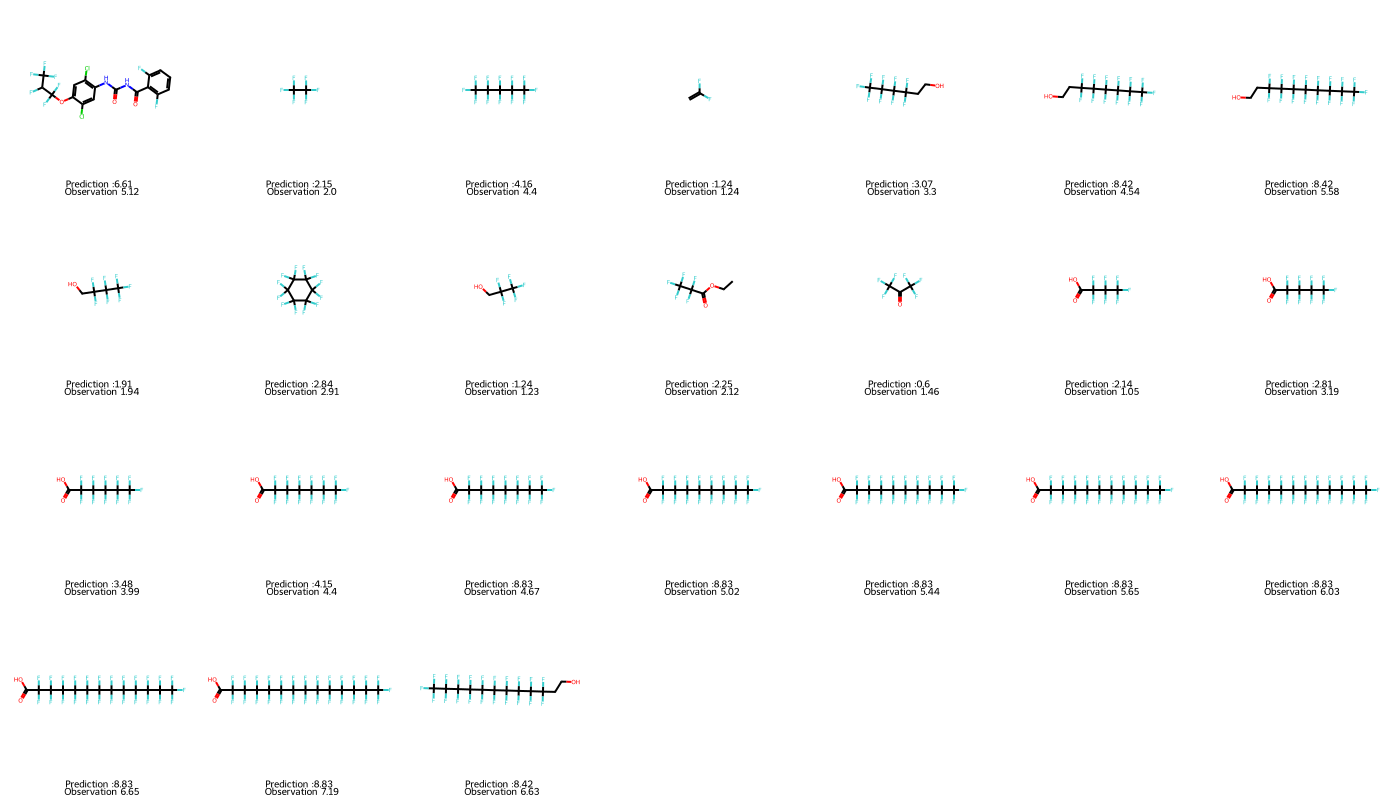

In [114]:
pd.set_option('display.max_rows', 24)
preds_vs_obs = pd.DataFrame({ "Predictions": predictions_test.round(2),  "Observations": test_labels["Experimental"]})
test_to_plot = test_smiles
PandasTools.AddMoleculeColumnToFrame(test_to_plot, smilesCol="SMILES")
Draw.MolsToGridImage(
    test_to_plot["ROMol"].head(24).to_list(),
    molsPerRow=7,
    subImgSize=(200, 200),
    legends=[
        "Prediction :{predictions} \n Observation {observations}".format(predictions = molecule["Predictions"], observations =  molecule["Observations"])
        for _, molecule in preds_vs_obs.head(24).iterrows()
        ]
)


# Part 3: Train a Jaqpot model (based on the Topological Fingerprints)

## Create jaqpotpy datasets to create and validate a molecular model

### the train dataset will be used to fit the model and the test dataset will be used for the evaluation of the model.

In [13]:
from jaqpotpy.datasets import SmilesDataset
from jaqpotpy.descriptors.molecular import TopologicalFingerprint


featurizer = TopologicalFingerprint()
train_dataset = SmilesDataset(smiles=train_smiles['SMILES'], y=train_labels, task = "regression", featurizer=featurizer)
test_dataset = SmilesDataset(smiles=test_smiles['SMILES'], y=test_labels, task = "regression", featurizer=featurizer)
train_dataset.create()
test_dataset.create()

OSError: [WinError 127] The specified procedure could not be found

# Create the evaluator for the model

In [ ]:
from jaqpotpy.models import Evaluator, MolecularTorchGeometric
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, matthews_corrcoef\
    , precision_score, recall_score, confusion_matrix


val = Evaluator()
val.dataset = test_dataset

val.register_scoring_function('Accuracy', accuracy_score)
val.register_scoring_function('Binary f1', f1_score)
val.register_scoring_function('Roc Auc', roc_auc_score)
val.register_scoring_function("MCC", matthews_corrcoef)
val.register_scoring_function("Precision", precision_score)
val.register_scoring_function("Recall", recall_score)
val.register_scoring_function("Confusion Matrix", confusion_matrix)

# Create a molecular Model with sklearn and jaqpotpy with the corresponding DOA

In [ ]:
from jaqpotpy.doa.doa import Leverage
from jaqpotpy.models import MolecularSKLearn

model = RandomForestClassifier(n_estimators=40, random_state=42)
molecular_dili_model = MolecularSKLearn(dataset=train_dataset, doa=Leverage(), model=model, eval=val).fit()

Accuracy: 0.7578947368421053
Binary f1: 0.7628865979381444
Roc Auc: 0.7577570921985817
MCC: 0.5157428445035049
Precision: 0.7551020408163265
Recall: 0.7708333333333334
Confusion Matrix: [[35 12]
 [11 37]]
